In [4]:
#Local
data_dir = 'C:/FSI/Googlecolab/dataset2'
train_dir = 'C:/FSI/Googlecolab/dataset2/train'
val_dir ='C:/FSI/Googlecolab/dataset2/val'
test_dir = 'C:/FSI/Googlecolab/dataset2/test'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/IAIMAGESFSI/dataset2'
train_dir = '/content/drive/MyDrive/IAIMAGESFSI/dataset2/train'
val_dir ='/content/drive/MyDrive/IAIMAGESFSI/dataset2/val'
test_dir = '/content/drive/MyDrive/IAIMAGESFSI/dataset2/test'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
import tensorflow as tf

# Establecer semillas para NumPy y TensorFlow
seed1 = 42
np.random.seed(seed=seed1)
random.seed(seed1)
tf.random.set_seed(seed1)

image_size = 150
batch_size = 32
rescale_factor = 1./255

# Leer imágenes y etiquetas
def load_images_and_labels(directory):
    images = []
    labels = []
    class_folders = os.listdir(directory)
    class_folders.sort()

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(directory, folder)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (image_size, image_size))
                img = img / 255.0  # Normalizar los valores de píxeles
                images.append(img)
                labels.append(i)

    return np.array(images), np.array(labels)

# Cargar imágenes de entrenamiento
train_images, train_labels = load_images_and_labels(train_dir)

# Cargar imágenes de validación
val_images, val_labels = load_images_and_labels(val_dir)

# Cargar imágenes de prueba
test_images, test_labels = load_images_and_labels(test_dir)



# Crear un generador de imágenes con data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Añadir 1000 imágenes con data augmentation al conjunto de entrenamiento
augmented_images = []
augmented_labels = []
num_augmented_images = 2000

for _ in range(num_augmented_images):
    index = random.randint(0, len(train_images) - 1)
    img = train_images[index]
    img = img.reshape((1,) + img.shape)
    label = train_labels[index]

    # Generar imagen aumentada
    augmented_img, _ = datagen.flow(img, [label], batch_size=1).next()

    augmented_images.append(augmented_img[0])
    augmented_labels.append(label)

# Convertir a numpy array
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenar imágenes aumentadas al conjunto de entrenamiento original
train_images = np.concatenate([train_images, augmented_images])
train_labels = np.concatenate([train_labels, augmented_labels])


# Dividir conjunto de entrenamiento en entrenamiento y validación
#train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=seed1)


In [6]:
from keras.regularizers import l2
from keras.optimizers.schedules.learning_rate_schedule import ExponentialDecay
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Congelar las capas convolucionales para no entrenarlas
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(len(os.listdir(train_dir)), activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo con un learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar la arquitectura del modelo
model.summary()

# Crear el objeto EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenar el modelo con Early Stopping y ReduceLROnPlateau
epochs = 200
history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_images, val_labels), callbacks=[early_stopping])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

44/44 [==============================] - 4s 85ms/step - loss: 1.1984 - accuracy: 0.8371
Test accuracy: 0.8371428847312927


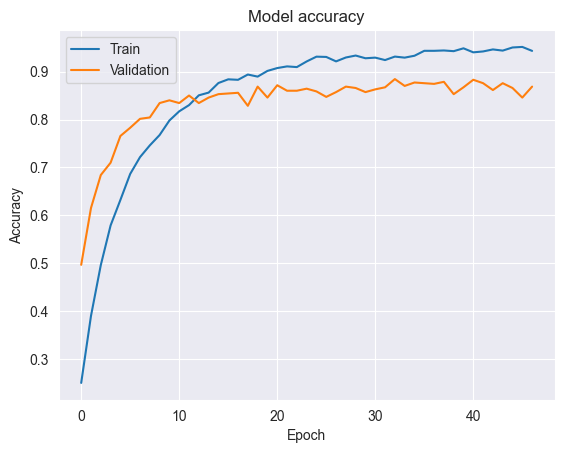

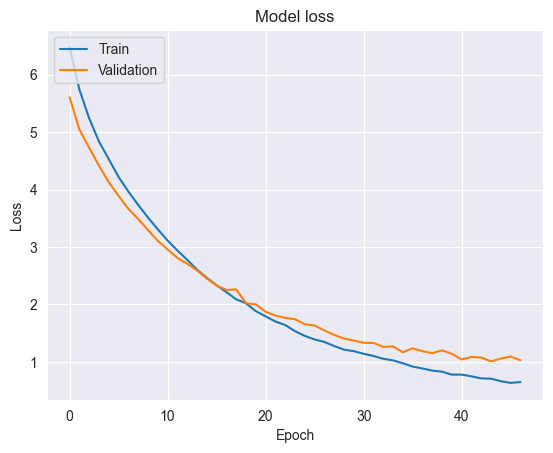

44/44 [==============================] - 2s 51ms/step
Matriz de Confusión:
[[150   5  16  16   7   4   2]
 [  0 136   6  29  23   5   1]
 [  0   0 191   3   3   2   1]
 [  0   4   9 156  28   0   3]
 [  0   2   6  32 153   5   2]
 [  2   0   0   0   2 192   4]
 [  0   2   0   1   3   0 194]]


<Axes: >

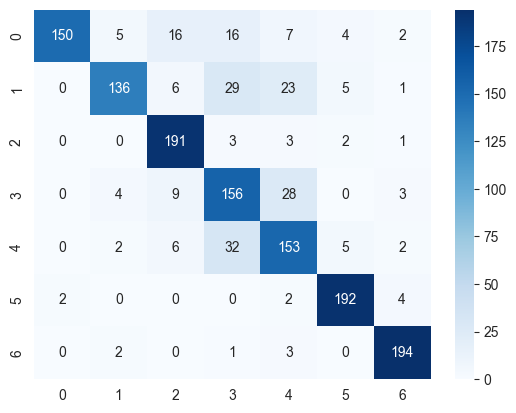

In [7]:
from sklearn.metrics import confusion_matrix
# Evaluar el modelo en datos de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Puedes usar history para visualizar la precisión y pérdida durante el entrenamiento
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Supongamos que ya has entrenado tu modelo y tienes imágenes de prueba y etiquetas de prueba
# Asegúrate de que el modelo está definido y entrenado antes de ejecutar esta parte del código

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(test_images)

# Obtener las etiquetas predichas (índice de la clase con mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Visualizar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")



44/44 [==============================] - 4s 84ms/step - loss: 0.6101 - accuracy: 0.8243
Test accuracy: 0.8242856860160828


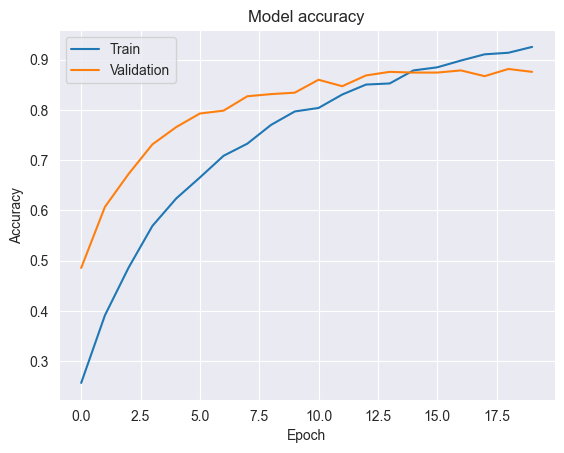

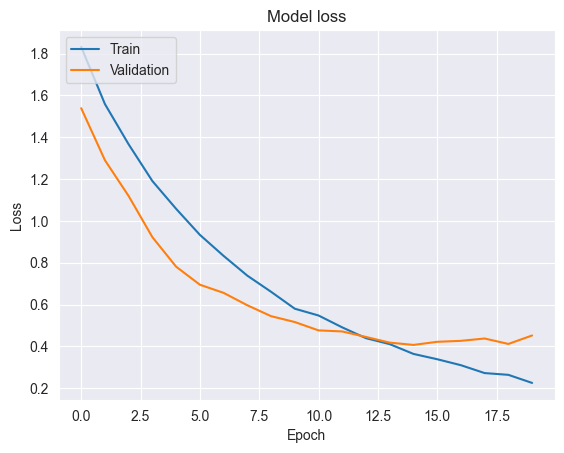

44/44 [==============================] - 2s 47ms/step
Matriz de Confusión:
[[164   2  17   7   6   2   2]
 [  1 134   5  28  19   1  12]
 [  2   0 195   1   1   1   0]
 [  1  15  18 123  36   1   6]
 [  3   5   8  25 151   3   5]
 [  2   0   0   1   0 194   3]
 [  0   2   0   0   1   4 193]]


<Axes: >

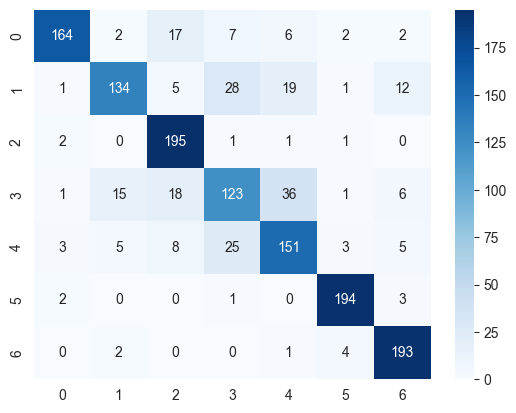

In [5]:
from sklearn.metrics import confusion_matrix
# Evaluar el modelo en datos de prueba
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Puedes usar history para visualizar la precisión y pérdida durante el entrenamiento
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Supongamos que ya has entrenado tu modelo y tienes imágenes de prueba y etiquetas de prueba
# Asegúrate de que el modelo está definido y entrenado antes de ejecutar esta parte del código

# Hacer predicciones en el conjunto de prueba
predictions = model.predict(test_images)

# Obtener las etiquetas predichas (índice de la clase con mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Obtener la matriz de confusión
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Visualizar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")



In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling,Activation
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

# Establecer semillas para NumPy y TensorFlow
seed1 = 47190
np.random.seed(seed=seed1)
random.seed(seed1)
tf.random.set_seed(seed1)

image_size = 150
batch_size = 16
rescale_factor = 1./255

# Crear un generador de datos de imagen con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,
    rotation_range=60,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',
    #validation_split= 0.2

)

# Preparar el generador para los datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    #subset='training',
    seed=seed1  # Establecer la semilla para el generador
)

# Preparar el generador para los datos de validación
valid_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse',
    #subset='validation',
    seed=seed1  # Establecer la semilla para el generador
)

# Preparar el generador para los datos de prueba
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='sparse'
)


Found 4900 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1400 images belonging to 7 classes.


In [ ]:
# Capa convolucional inicial con inicialización de pesos
model = Sequential()
model.add(Conv2D(64, (4, 4), input_shape=(image_size, image_size, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
# Capas totalmente conectadas

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

In [ ]:
from keras.layers import Conv2D, BatchNormalization, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.initializers import GlorotNormal
import matplotlib.pyplot as plt
from tensorflow.keras import layers
# Capa convolucional inicial con inicialización de pesos
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(image_size, image_size, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (5, 5), input_shape=(image_size, image_size, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
# Capas totalmente conectadas

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))




# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Imprimir resumen del modelo
#model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
desired_steps_per_epoch = 75
epochs = 100

# Entrenamiento del modelo con EarlyStopping
history = model.fit(
    train_images,
    epochs=epochs,
    validation_data=valid_images,
    batch_size=batch_size,
     steps_per_epoch=desired_steps_per_epoch,
    callbacks=[early_stopping]
)

# Guardar el modelo después del entrenamiento
model.save('modelo_entrenado.h5')

# Mostrar gráficamente el progreso del entrenamiento
# Gráficos para la precisión
plt.plot(history.history['acc'], label='train accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gráficos para la pérdida
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100
75/75 [==============================] - 37s 440ms/step - loss: 1.9484 - acc: 0.1383 - val_loss: 1.9422 - val_acc: 0.1743
Epoch 2/100
75/75 [==============================] - 32s 426ms/step - loss: 1.9294 - acc: 0.1787 - val_loss: 1.9059 - val_acc: 0.2371
Epoch 3/100
75/75 [==============================] - 33s 436ms/step - loss: 1.8144 - acc: 0.2336 - val_loss: 1.7357 - val_acc: 0.2614
Epoch 4/100
75/75 [==============================] - 35s 466ms/step - loss: 1.6639 - acc: 0.2858 - val_loss: 1.6816 - val_acc: 0.3143
Epoch 5/100
75/75 [==============================] - 32s 433ms/step - loss: 1.6000 - acc: 0.3170 - val_loss: 1.6038 - val_acc: 0.3500
Epoch 6/100
75/75 [==============================] - 43s 573ms/step - loss: 1.5321 - acc: 0.3521 - val_loss: 1.5749 - val_acc: 0.4000
Epoch 7/100
75/75 [==============================] - 32s 428ms/step - loss: 1.4771 - acc: 0.3807 - val_loss: 1.5415 - val_acc: 0.3786
Epoch 8/100
75/75 [==============================] - 32s 433ms

KeyboardInterrupt: ignored

Se realiza un preprocesamiento de datos, que incluye aumentación de imágenes, y se crean generadores de datos para los conjuntos de entrenamiento, validación y prueba. El modelo CNN consta de capas convolucionales, de agrupación y completamente conectadas, y se entrena utilizando el generador de datos de entrenamiento. Se utiliza un conjunto de datos de validación para evitar el sobreajuste. Finalmente, el modelo se evalúa en el conjunto de prueba, y se calcula la matriz de confusión para evaluar su rendimiento en la clasificación de imágenes.

Este fragmento se muestra dos imágenes del lote de entrenamiento generado por train_generator

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 200

# Entrenar el modelo con Early Stopping
history_of_train = model.fit(
        train_generator,
        epochs=epochs,
        validation_data = valid_generator,
        callbacks = [early_stopping]
)


Epoch 1/200


ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

def generatePlot(history):
    # Extracción de datos
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.ylim(0, 1)  # Establecer límites en el eje y de 0 a 1

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    #plt.ylim(0, 1)  # Establecer límites en el eje y de 0 a 1

    plt.tight_layout()
    plt.show()

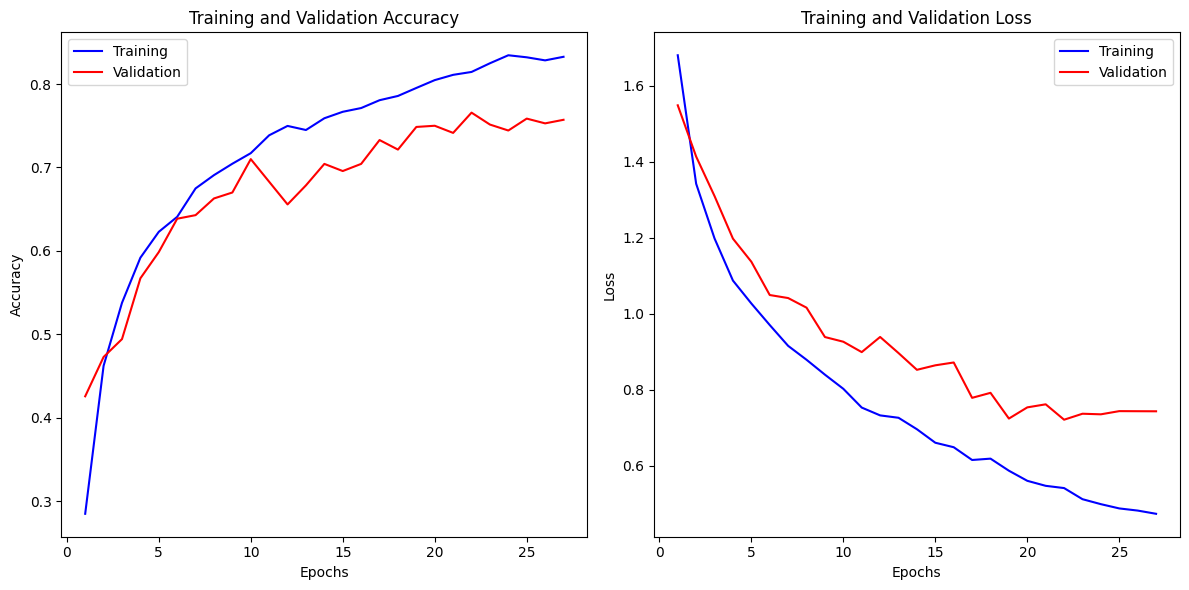

In [ ]:
generatePlot(history)